In [3]:
import numpy as np
import scipy.stats as st
import scipy.special as sp
import math
import matplotlib.pyplot as plt
from scipy.stats import invwishart
from scipy.stats import multivariate_normal
from numpy import matrix
from numpy import linalg
from numpy import arange
from math import exp, expm1, pi,sin

In [4]:
def transmatrix(dimension):
    Xmatrix=[]
    if dimension==2:
        Xmatrix=np.matrix(((1,1,1,0), (1,1,-1,0),(1,-1,0,1),(1,-1,0,-1)))
    return Xmatrix

In [5]:
X=transmatrix(2)
XT=X.transpose()
XT*X

matrix([[4, 0, 0, 0],
        [0, 4, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])

In [6]:
#DataX=X-coordinate values of time series data 
def SigmaGPGen(DataX):
    dim=len(DataX)
    SigmaGP=np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            SigmaGP[i,j]=exp(-0.5*(abs(DataX[i]-DataX[j])/1)**2)
    return SigmaGP

In [7]:
def gpfunction(size):
    x=arange(1,size+1)/size
    y=np.sin(2*np.pi*x)
    return y

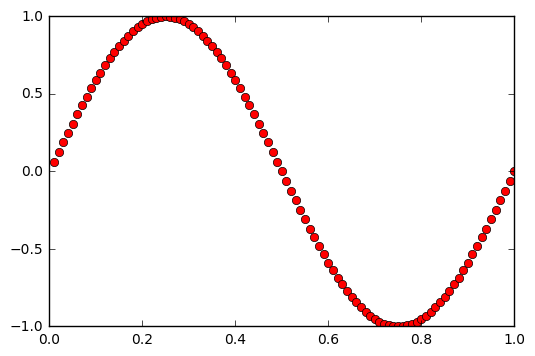

In [8]:
size=100
plt.plot(arange(1,size+1)/size,gpfunction(size),'ro')
plt.show()

In [18]:
############# Generate GP Data with a mean of gpfunction. Each row in output matrix is a sample ##########
def GPDataGen(n_samples,J,plot):
    x=arange(1,2**J+1)/(2**J)
    Sigma=SigmaGPGen(x)
    Data=np.zeros((n_samples,len(x)))
    for i in range(0,(n_samples)):
        Data[i,:]=np.random.multivariate_normal(gpfunction(2**J), Sigma, 1)
    if plot==0:
        return Data
    if plot==1:
        for i in range(0,Data.shape[0]):
            plt.plot(x,Data[i,:],'ro')
            plt.show()
        

In [10]:
#####################################################################################################################
#Drawing from Posterior
#Sum of Squares Matrix 
def SSMatrix(Data):
    mean=Data.mean(axis=0)
    SS=np.zeros((Data.shape[1],Data.shape[1]))
    for i in range(0,Data.shape[0]):
        AddMatrix=np.outer((Data[i,:]-mean),(Data[i,:]-mean))
        SS=SS+AddMatrix
    return SS

In [11]:
def DrawPosteriorSigma(Data,nu_0,scale_matrix_0):
    mean=Data.mean(axis=0)
    SS=SSMatrix(Data)
    n=Data.shape[0]
    #NewParameters
    nu_n=nu_0+n
    scale_matrix_n=scale_matrix_0+SS+kappa_0*n/(kappa_0+n)*np.outer((mean-mu_0),(mean-mu_0))
    return invwishart.rvs(nu_n, scale_matrix_n, size=1, random_state=None)

In [12]:
def DrawPosteriorMean(Data,mu_0,kappa_0,SigmaDrawn):
    mean=Data.mean(axis=0)
    SS=SSMatrix(Data)
    n=Data.shape[0]
    #NewParameters
    mu_n=kappa_0/(kappa_0+n)*mu_0+n/(kappa_0+n)*mean
    kappa_n=kappa_0+n
    return multivariate_normal.rvs(mu_n,SigmaDrawn/kappa_n)

In [23]:
###########################Example using the functions above with J=2######################################################
samples_drawn=100
Datasize=100
J=2
def PosteriorDraw(Datasize,J,samples_drawn):
    Data=GPDataGen(Datasize,J,0)
    #Parameters
    nu_0=Data.shape[1]+1 #df=dimension of data+1
    scale_matrix_0=np.identity(Data.shape[1]) #scale matrix set to identity matrix 
    mu_0=np.array([0]*Data.shape[1]) #Prior mean set to 0 vector
    kappa_0=0 #Number of prior measurements 
    sigma_squared=0.01**2 #noise 
    #Draw Sigma and Mu (mean)
    Total_SigmaStar_Drawn=[]
    Total_MuStar_Drawn=[]
    for i in range(0,samples_drawn):
        SigmaDrawn=DrawPosteriorSigma(Data,nu_0,scale_matrix_0)
        print(SigmaDrawn)
        MeanDrawn=DrawPosteriorMean(Data,mu_0,kappa_0,SigmaDrawn)
        #Convert Sigma and Mu to Sigma_star and Mu_Star
        X=transmatrix(J)
        XT=X.transpose()
        Total_MuStar_Drawn.append(np.dot(linalg.inv(X),MeanDrawn))
        Total_SigmaStar_Drawn.append(np.dot(np.dot(linalg.inv(XT),(SigmaDrawn-np.identity(Data.shape[1])*sigma_squared)),linalg.inv(X)))
    return(Total_MuStar_Drawn,Total_SigmaStar_Drawn)


In [21]:
###########################Example using the functions above with J=2######################################################
samples_drawn=100
Datasize=100
J=2
Data=GPDataGen(Datasize,J,0)
#Parameters
nu_0=Data.shape[1]+1 #df=dimension of data+1
scale_matrix_0=np.identity(Data.shape[1]) #scale matrix set to identity matrix 
mu_0=np.array([0]*Data.shape[1]) #Prior mean set to 0 vector
kappa_0=0 #Number of prior measurements 
sigma_squared=0.01**2 #noise 
#Draw Sigma and Mu (mean)
Total_SigmaStar_Drawn=[]
Total_MuStar_Drawn=[]
for i in range(0,samples_drawn):
    SigmaDrawn=DrawPosteriorSigma(Data,nu_0,scale_matrix_0)
    print(SigmaDrawn)
    MeanDrawn=DrawPosteriorMean(Data,mu_0,kappa_0,SigmaDrawn)
    #Convert Sigma and Mu to Sigma_star and Mu_Star
    X=transmatrix(J)
    XT=X.transpose()
    Total_MuStar_Drawn.append(np.dot(linalg.inv(X),MeanDrawn))
    Total_SigmaStar_Drawn.append(np.dot(np.dot(linalg.inv(XT),(SigmaDrawn-np.identity(Data.shape[1])*sigma_squared)),linalg.inv(X)))
return(Total_MuStar_Drawn,Total_SigmaStar_Drawn)


[[ 0.89021079  0.87455131  0.80148261  0.70100664]
 [ 0.87455131  0.92857572  0.89243488  0.81965374]
 [ 0.80148261  0.89243488  0.92056261  0.88087431]
 [ 0.70100664  0.81965374  0.88087431  0.9009109 ]]
[[ 1.31967648  1.22948533  1.10149693  0.94294597]
 [ 1.22948533  1.22030314  1.14324784  1.01697976]
 [ 1.10149693  1.14324784  1.14000096  1.0576385 ]
 [ 0.94294597  1.01697976  1.0576385   1.05148512]]
[[ 1.24814882  1.19507342  1.07378477  0.91002152]
 [ 1.19507342  1.21887486  1.15128636  1.03077378]
 [ 1.07378477  1.15128636  1.18517578  1.12216212]
 [ 0.91002152  1.03077378  1.12216212  1.15077702]]
[[ 1.23229352  1.19133299  1.06219338  0.92709441]
 [ 1.19133299  1.24814057  1.1766593   1.09109238]
 [ 1.06219338  1.1766593   1.20193969  1.17013538]
 [ 0.92709441  1.09109238  1.17013538  1.21167789]]
[[ 1.13669775  1.08789236  0.92221523  0.74770879]
 [ 1.08789236  1.11714267  1.00355674  0.86986094]
 [ 0.92221523  1.00355674  0.990801    0.91256864]
 [ 0.74770879  0.86986094  

SyntaxError: 'return' outside function (<ipython-input-21-3888a8b448c5>, line 24)

In [14]:
PosteriorDraw(Datasize,J,samples_drawn)

NameError: name 'kappa_0' is not defined

In [15]:
##############################Sampling the Data using the posterior samples for Mu and Sigma###################

DataDrawn=multivariate_normal.rvs(MeanDrawn,SigmaDrawn,size=5, random_state=None)
J=2
x=arange(1,2**J+1)/(2**J)
for i in range(0,DataDrawn.shape[0]):
    plt.plot(x,DataDrawn[i,:],'ro')
    plt.show()                        

NameError: name 'MeanDrawn' is not defined

In [23]:
DataDrawn

array([[-0.25821856, -1.22962553, -1.7625888 ,  0.03323939],
       [ 0.20490261, -1.03721394, -2.24753433, -1.01693628],
       [ 0.8492656 , -0.37468644, -1.40057043, -0.65377938],
       [ 0.12186466, -1.24448294, -2.03907781, -0.83772988],
       [ 1.46227526,  0.14288613, -0.39632877,  1.0380118 ]])

In [15]:
#######################################################################################
##Metropolis Hastings
def MHAlg(Data,n): #n=number of iterations
    n_samples=Data.shape[0] #Number of rows of data=number of samples
    n_datap=Data.shape[1] #Number of columns=number of data points
    res=int(math.log(n_datap)/math.log(2)) #resolution
    initscale=np.array([0]*n)
    loglike=np.array([0]*n)
    logprior=np.array([0]*n)
    logp=np.array([0]*n)
    theta=np.array([0]*n)
    detail_coef=[np.array([[0]*n])]
    for i in range(1,J):
        appendmatrix=np.array([[0]*n]*(2**i))
        detail_coef.append(appendmatrix)
    #detail_coef_star
    detail_coef_star=detail_coef
    detail_coef_means=detail_coef
    #Start values for coefficients, i.e. mu_star(iteration 1)
    initscale[1]=##RNORMGENERATE
    for j in range(0,res):
        for k in range(0,2**(j)):
            detail_coef[j][k,1]=##RNORM generate
    #Start value for covariance matrix i.e. Sigma_Star 
    
    #calculate log like
    coeffvec=[]
    for j in range(0,res):
        coeffvec=[np.array([detail_coef[0][:,1]])]
        coeffvec.append(detail_coef[j][:,1])
    
                
        

SyntaxError: invalid syntax (<ipython-input-15-ac789b0643bd>, line 20)

In [21]:
detail_coef=[np.array([[0]*2]*1)]
A=np.array([[0]*2]*2)
detail_coef.append(A)
detail_coef[1][:,1] #indexing. 

array([[0, 0],
       [0, 0]])

In [223]:
MHAlg(Data,2)

In [211]:
detail_coef[0]

array([[0, 0, 0, 0, 0]])

In [32]:
a=[np.identity(2)]
b=a*2
c=a*3
d=np.identity(3)

In [182]:
a.append(d)

In [183]:
a

[array([[ 1.,  0.],
        [ 0.,  1.]]), array([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])]

In [123]:
a[1]

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [127]:
a[0][0,1]

0.0

In [35]:
coeffvec=[]

In [36]:
coeffvec.append(a)

In [37]:
coeffvec

[[array([[ 1.,  0.],
         [ 0.,  1.]])]]